Document for Model training



Importing packages

In [1]:
import random
import math
import matplotlib.pyplot as plt
from PIL import ImageDraw, Image
import bifurcationMathFunctions as bmf
import numpy as np

Setting Constants

In [1]:
startX = 5
startY = 200
startAngle = 0
starWidth = 15
stopWidth = 2
startLength = 20
#bifurcProb = 0.3
#bifurcBigLeft = 0.5

Synthetic Angiogram Class: Node

Synthetic Angiogram Class: Tree

Drawing Tree

Executing

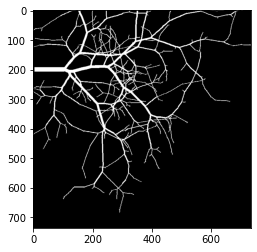

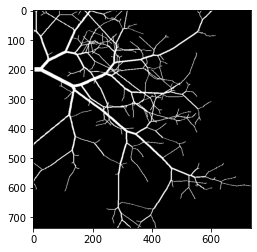

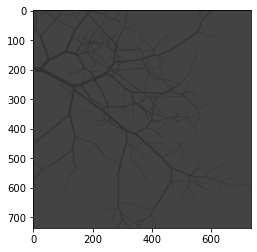

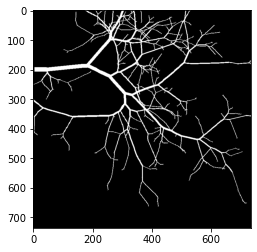

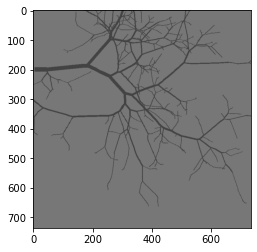

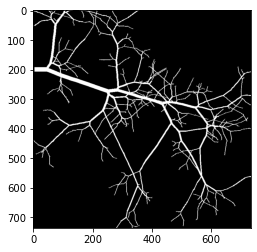

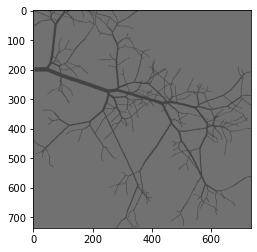

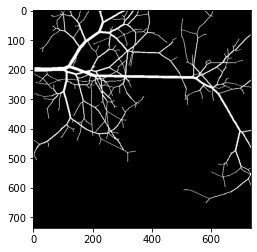

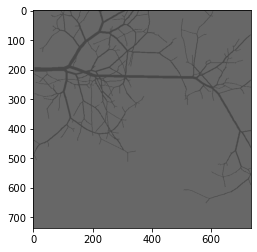

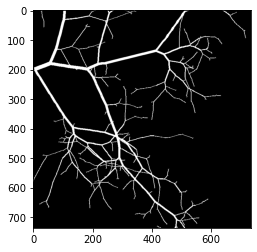

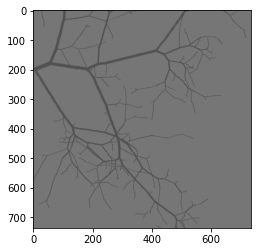

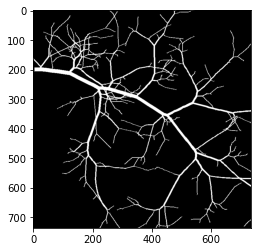

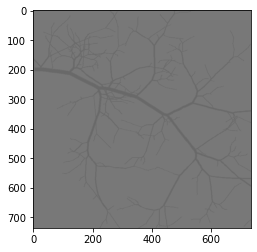

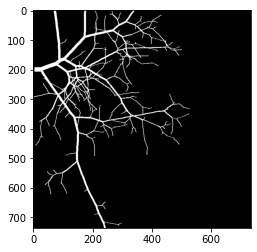

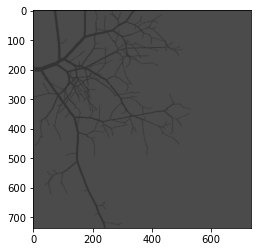

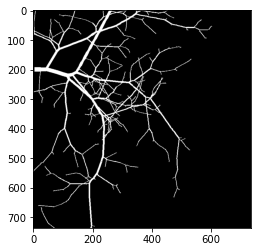

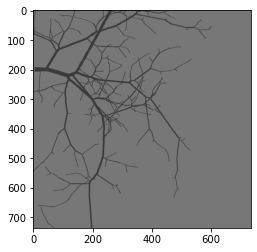

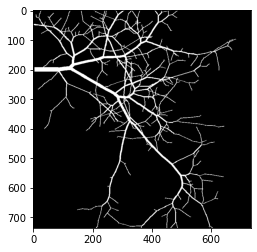

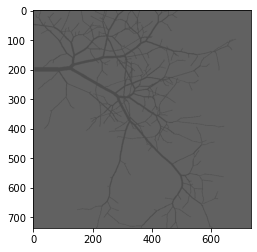

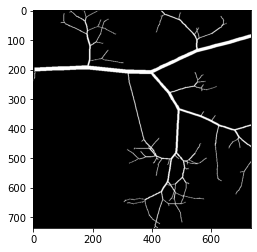

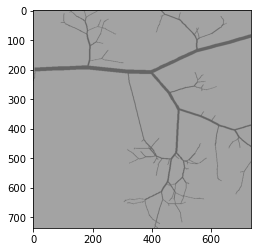

In [2]:
from TreeLib import Tree
from TreeLib import drawTree, genTree
from genInputFromLabel import labelToInput
tree = Tree(startX, startY, starWidth, startLength, startAngle, stopWidth)
synAngio = genTree(tree, (736, 736))
drawTree(synAngio)

for i in range(10):
    tree = Tree(startX, startY, starWidth,startLength, startAngle,stopWidth)
    synAngioLab = genTree(tree, (736, 736))
    synAngioInput = labelToInput(synAngioLab)
    drawTree(synAngioLab)
    drawTree(synAngioInput)

In [ ]:
#synAngio.save("test_image.PNG")